In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
from torchvision.datasets import ImageFolder, MNIST
from torchvision import transforms
from torch import autograd
from torch.autograd import Variable
from torchvision.utils import make_grid
from tensorboardX import SummaryWriter

In [2]:
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
])

In [3]:
batch_size = 32
data_loader = torch.utils.data.DataLoader(MNIST('data', train=True, download=True, transform=transform),
                                          batch_size=batch_size, shuffle=True)

In [4]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.label_emb = nn.Embedding(10, 10)
        
        self.model = nn.Sequential(
            nn.Linear(794, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x, labels):
        x = x.view(x.size(0), 784)
        c = self.label_emb(labels)
        x = torch.cat([x, c], 1)
        out = self.model(x)
        return out.squeeze()

In [5]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.label_emb = nn.Embedding(10, 10)
        
        self.model = nn.Sequential(
            nn.Linear(110, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 784),
            nn.Tanh()
        )
    
    def forward(self, z, labels):
        z = z.view(z.size(0), 100)
        c = self.label_emb(labels)
        x = torch.cat([z, c], 1)
        out = self.model(x)
        return out.view(x.size(0), 28, 28)

In [6]:
generator = Generator().cuda()
discriminator = Discriminator().cuda()

In [7]:
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=1e-4)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=1e-4)

In [8]:
writer = SummaryWriter()

In [9]:
def generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion):
    g_optimizer.zero_grad()
    z = Variable(torch.randn(batch_size, 100)).cuda()
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, 10, batch_size))).cuda()
    fake_images = generator(z, fake_labels)
    validity = discriminator(fake_images, fake_labels)
    g_loss = criterion(validity, Variable(torch.ones(batch_size)).cuda())
    g_loss.backward()
    g_optimizer.step()
    return g_loss.item()

In [10]:
def discriminator_train_step(batch_size, discriminator, generator, d_optimizer, criterion, real_images, labels):
    d_optimizer.zero_grad()

    # train with real images
    real_validity = discriminator(real_images, labels)
    real_loss = criterion(real_validity, Variable(torch.ones(batch_size)).cuda())
    
    # train with fake images
    z = Variable(torch.randn(batch_size, 100)).cuda()
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, 10, batch_size))).cuda()
    fake_images = generator(z, fake_labels)
    fake_validity = discriminator(fake_images, fake_labels)
    fake_loss = criterion(fake_validity, Variable(torch.zeros(batch_size)).cuda())
    
    d_loss = real_loss + fake_loss
    d_loss.backward()
    d_optimizer.step()
    return d_loss.item()

In [11]:
num_epochs = 50
n_critic = 5
display_step = 50
for epoch in range(num_epochs):
    print('Starting epoch {}...'.format(epoch), end=' ')
    for i, (images, labels) in enumerate(data_loader):
        
        step = epoch * len(data_loader) + i + 1
        real_images = Variable(images).cuda()
        labels = Variable(labels).cuda()
        generator.train()
        
        d_loss = 0
        for _ in range(n_critic):
            d_loss = discriminator_train_step(len(real_images), discriminator,
                                              generator, d_optimizer, criterion,
                                              real_images, labels)
        

        g_loss = generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion)
        
        writer.add_scalars('scalars', {'g_loss': g_loss, 'd_loss': (d_loss / n_critic)}, step)  
        
        if step % display_step == 0:
            generator.eval()
            z = Variable(torch.randn(9, 100)).cuda()
            labels = Variable(torch.LongTensor(np.arange(9))).cuda()
            sample_images = generator(z, labels).unsqueeze(1)
            grid = make_grid(sample_images, nrow=3, normalize=True)
            writer.add_image('sample_image', grid, step)
    print('Done!')

Starting epoch 0... Done!
Starting epoch 1... Done!
Starting epoch 2... Done!
Starting epoch 3... Done!
Starting epoch 4... Done!
Starting epoch 5... Done!
Starting epoch 6... Done!
Starting epoch 7... Done!
Starting epoch 8... Done!
Starting epoch 9... Done!
Starting epoch 10... Done!
Starting epoch 11... Done!
Starting epoch 12... Done!
Starting epoch 13... Done!
Starting epoch 14... Done!
Starting epoch 15... Done!
Starting epoch 16... Done!
Starting epoch 17... Done!
Starting epoch 18... Done!
Starting epoch 19... Done!
Starting epoch 20... Done!
Starting epoch 21... Done!
Starting epoch 22... Done!
Starting epoch 23... Done!
Starting epoch 24... Done!
Starting epoch 25... Done!
Starting epoch 26... Done!
Starting epoch 27... Done!
Starting epoch 28... Done!
Starting epoch 29... Done!
Starting epoch 30... Done!
Starting epoch 31... Done!
Starting epoch 32... Done!
Starting epoch 33... Done!
Starting epoch 34... Done!
Starting epoch 35... Done!
Starting epoch 36... Done!
Starting ep

In [12]:
torch.save(generator.state_dict(), 'generator_state.pt')

In [120]:
z = Variable(torch.randn(100, 100)).cuda()
labels = torch.LongTensor([i for i in range(10) for _ in range(10)]).cuda()

In [135]:
images = generator(z, labels).unsqueeze(1)

In [219]:
grid = make_grid(images, nrow=10, normalize=True)

(-0.5, 301.5, 301.5, -0.5)

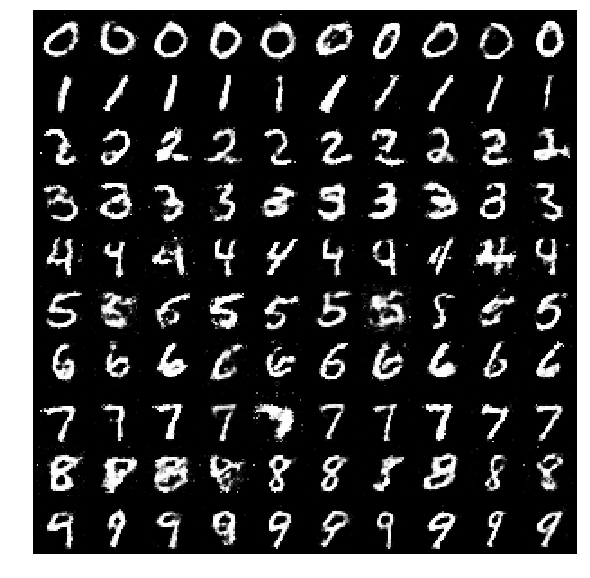

In [233]:
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(grid.permute(1, 2, 0).data, cmap='binary')
ax.axis('off')

In [51]:
def generate_digit(generator, digit):
    z = Variable(torch.randn(1, 100)).cuda()
    label = torch.LongTensor([digit]).cuda()
    img = generator(z, label).data.cpu()
    img = 0.5 * img + 0.5
    return transforms.ToPILImage()(img)

In [218]:
generate_digit(generator, 8)